In [3]:
import xarray as xr

# Specify the path to your NetCDF file
file_path = 'transect_r20240117.nc'
file_path = r'C:\Users\fuentesm\Marilu\Deltares\Projects\Westerchelde\Data\S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc'
#file_path ='http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/jarkus/profiles/transect.nc' 

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

# Display the dataset information
# print(ds)


In [267]:
import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import altair as alt
import numpy as np

folder_path = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/'
folder_path_stations = 'C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/Stations.xlsx'   

# List all files in the folder
files_in_folder = os.listdir(folder_path)

# Filter the list to include only files ending with "ic.nc"
filtered_files = [file for file in files_in_folder if file.endswith("L2W.nc")]

filtered_files.sort()

datasets_list = []
# Print the list of matching files
for file in filtered_files:
    path = os.path.join(folder_path , file)
    print(path)
    dataset = xr.open_dataset(path)
    time_series = [datetime.fromisoformat(dataset.attrs.get("isodate"))]  # Replace with your time series data
    ##new_dataset = xr.concat([dataset["chl_re_gons"]], dim=xr.DataArray(time_series, coords={"time": time_series}, dims=["time"]))
    new_dataset = xr.concat([dataset], dim=xr.DataArray(time_series, coords={"time": time_series}, dims=["time"]))
    datasets_list.append(new_dataset)

merged_data = xr.concat(datasets_list, dim='time')


C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2015_07_16_10_50_24_merged_westerschelde_L2W.nc
C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data/S2A_MSI_2023_08_23_10_56_47_merged_westerschelde_L2W.nc


In [268]:
def get_window(x_coord, y_coord, stationID):
    time_series = merged_data.sel(x=x_coord, y=y_coord, method='nearest')
    y_coord_exact = time_series['y'].values.tolist()
    x_coord_exact = time_series['x'].values.tolist()
    y_index = np.where(merged_data['y'] == y_coord_exact)[0].tolist()[0]
    x_index = np.where(merged_data['x'] == x_coord_exact)[0].tolist()[0]
    central_lon  = x_index
    central_lat  = y_index

    lat_start, lat_end = central_lat - 1, central_lat + 2
    lon_start, lon_end = central_lon - 1, central_lon + 2

    window_values = merged_data.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end))
    window_values = window_values.expand_dims(station=[stationID])

    return window_values

# stationID = 'S1'
# station = 'SCHAARVODDL	Schaar van Ouden Doel'
# lon = 4.250932603
# lat = 51.35118367
# x_coord =  5.8711167e+05 #5.208e+05  
# y_coord =  5.68962179e+06

# stationID = 'S2'
# station = 'VLISSGNLDK	Vlissingen Nolledijk'
# lon = 3.553066,	
# lat = 51.450453
# x_coord =  5.3843131e+05   
# y_coord =  5.70006397e+06 

df = pd.read_excel(folder_path_stations)

stations_list = []
for index, row in df.iterrows():
    # print(row['stationID'])
    station_window = get_window(row['x_coord'], row['y_coord'], row['stationID'])
    stations_list.append(station_window)

merged_stations = xr.concat(stations_list, dim='station')
# station1 = get_window(x_coord, y_coord, stationID)

In [269]:
merged_stations

<xarray.Dataset>
Dimensions:              (x: 6, y: 6, time: 2, station: 2)
Coordinates:
  * x                    (x) float64 5.384e+05 5.384e+05 ... 5.871e+05 5.872e+05
  * y                    (y) float64 5.69e+06 5.69e+06 ... 5.7e+06 5.7e+06
  * time                 (time) object 1437043824456000000 1692788207527148000
  * station              (station) object 'S1' 'S2'
Data variables:
    transverse_mercator  (station, time) float64 9.969e+36 ... 9.969e+36
    lon                  (station, time, y, x) float32 nan nan nan ... nan nan
    lat                  (station, time, y, x) float32 nan nan nan ... nan nan
    l2_flags             (station, time, y, x) float64 nan nan nan ... nan nan
    chl_re_gons          (station, time, y, x) float32 nan nan nan ... nan nan
Attributes: (12/381)
    generated_by:                              ACOLITE
    generated_on:                              2024-01-18 10:07:11 CET
    contact:                                   Quinten Vanhellemont
    product_type:                              NetCDF
    metadata_profile:                          beam
    metadata_version:                          0.5
    ...                                        ...
    luts:                                      ['ACOLITE-LUT-202110-MOD1', 'A...
    luts_pressures:                            [ 500  750 1013 1100]
    slicing:                                   False
    scene_download:                            False
    runid:                                     20240118_100708
    inputfile:                                 ['/eodc/private/deltares/INPUT...

In [270]:
# Extract variable name (replace with your actual variable name)
variable_name = 'chl_re_gons'

# Get the latitude and longitude coordinates
latitudes = merged_stations['y'].values
longitudes = merged_stations['x'].values
times = merged_stations['time'].values
stations = merged_stations['station'].values

# Initialize lists to store data
pixel_values = []
coordinates = []

# Iterate over latitudes and longitudes
for station_index, station in enumerate(stations):
    for time_index, time in enumerate(times):
        for lat_index, lat in enumerate(latitudes):
            for lon_index, lon in enumerate(longitudes):
                
                # Extract pixel value
                ##pixel_value = merged_stations[variable_name].isel(y=lat_index, x=lon_index, time=time_index, station=station_index).values.item()
                pixel_value = merged_stations[variable_name].sel(station=station).isel(y=lat_index, x=lon_index, time=time_index).values
                print(pixel_value)

                # Append data to lists
                pixel_values.append(pixel_value)
                coordinates.append((lat, lon, station, time))


df = pd.DataFrame({
    'Latitude': [coord[0] for coord in coordinates],
    'Longitude': [coord[1] for coord in coordinates],
    'Station': [coord[2] for coord in coordinates],
    'Time': [coord[3] for coord in coordinates],
    'Pixel_Value': pixel_values
})

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
9.5094
8.627829
9.061846
nan
nan
nan
10.720591
8.832928
9.110658
nan
nan
nan
9.434819
9.329641
9.309038
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'Latitude': [coord[0] for coord in coordinates],
    'Longitude': [coord[1] for coord in coordinates],
    'Pixel_Value': pixel_values
})

# Save the DataFrame to an Excel file
excel_output_path = 'pixel_values_coordinates.xlsx'
df.to_excel(excel_output_path, index=False)

# Close the xarray dataset
ds.close()

print(f'Data exported to {excel_output_path}')

In [134]:
# Specify the 'x' and 'y' coordinates for the time series
stationID = '1'
x_coord =  5.8711167e+05 #5.208e+05
y_coord =  5.68962179e+06 #5.712e+06

# Extract the time series at the specified 'x' and 'y' coordinates
time_series = merged_data.sel(x=x_coord, y=y_coord, method='nearest')
y_coord_exact = time_series['y'].values.tolist()
x_coord_exact = time_series['x'].values.tolist()
y_index = np.where(merged_data['y'] == y_coord_exact)[0].tolist()[0]
x_index = np.where(merged_data['x'] == x_coord_exact)[0].tolist()[0]

central_lon  = x_index
central_lat  = y_index

lat_start, lat_end = central_lat - 1, central_lat + 2
lon_start, lon_end = central_lon - 1, central_lon + 2

window_values = merged_data.isel(y=slice(lat_start, lat_end), x=slice(lon_start, lon_end))
window_values = window_values.expand_dims(station=[stationID])

In [135]:
window_values

<xarray.Dataset>
Dimensions:              (station: 1, time: 2, x: 3, y: 3)
Coordinates:
  * station              (station) object '1'
  * x                    (x) float64 5.871e+05 5.871e+05 5.872e+05
  * y                    (y) float64 5.69e+06 5.69e+06 5.69e+06
  * time                 (time) object 1437043824456000000 1692788207527148000
Data variables:
    transverse_mercator  (station, time) float64 9.969e+36 9.969e+36
    lon                  (station, time, y, x) float32 4.25 4.251 ... 4.252
    lat                  (station, time, y, x) float32 51.35 51.35 ... 51.35
    l2_flags             (station, time, y, x) int32 1 1 1 1 1 1 ... 0 0 0 0 0 0
    chl_re_gons          (station, time, y, x) float32 nan nan ... 8.628 9.062
Attributes: (12/381)
    generated_by:                              ACOLITE
    generated_on:                              2024-01-18 10:07:11 CET
    contact:                                   Quinten Vanhellemont
    product_type:                              NetCDF
    metadata_profile:                          beam
    metadata_version:                          0.5
    ...                                        ...
    luts:                                      ['ACOLITE-LUT-202110-MOD1', 'A...
    luts_pressures:                            [ 500  750 1013 1100]
    slicing:                                   False
    scene_download:                            False
    runid:                                     20240118_100708
    inputfile:                                 ['/eodc/private/deltares/INPUT...

C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data//plot_ch.png
C:/Users/fuentesm/Marilu/Deltares/Projects/Westerchelde/Data//plot_ch_atl.html


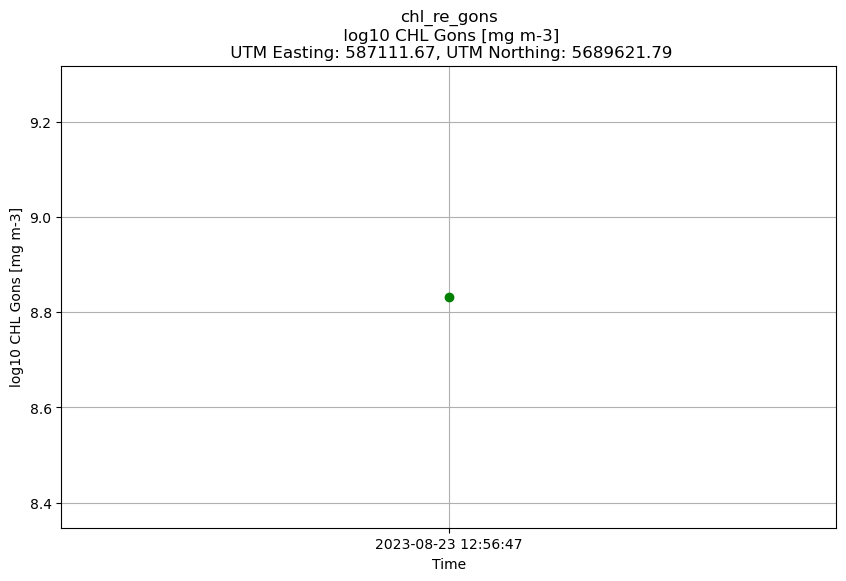

In [28]:
# Specify the 'x' and 'y' coordinates for the time series
x_coord =  5.8711167e+05 #5.208e+05
y_coord =  5.68962179e+06 #5.712e+06

# x_coord =  5.208e+05
# y_coord =  5.712e+06

# Extract the time series at the specified 'x' and 'y' coordinates
time_series = merged_data.sel(x=x_coord, y=y_coord, method='nearest')

ch = time_series.values.tolist()
time = time_series.time.values.tolist()
time = [x / 1e9 for x in time]
date_strings = [datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S') for timestamp in time]

plt.figure(figsize=(10, 6))
plt.plot(date_strings, ch, marker='o', color='g')
plt.title(f'chl_re_gons\n log10 CHL Gons [mg m-3]\n UTM Easting: {x_coord}, UTM Northing: {y_coord}')
plt.xlabel('Time')
plt.ylabel('log10 CHL Gons [mg m-3]')
plt.grid(True)

output_filename = folder_path + '/plot_ch.png'
print(output_filename)
plt.savefig(output_filename)


data = pd.DataFrame({'Date': date_strings, 'CHL': ch})
y_axis_limits = (0, 10)

# Create an Altair chart
chart = alt.Chart(data.dropna()).mark_bar(size=10).encode(
    x='Date:T',
    y='CHL:Q',
    # scale=alt.Scale(domain=list(y_axis_limits)),
    color=alt.Color(
        'CHL:Q', scale=alt.Scale(scheme='redyellowgreen', domain=(5, 20))),
    tooltip=[
        alt.Tooltip('Date:T', title='Date'),
        alt.Tooltip('log10 CHL Gons [mg m-3]:Q', title='log10 CHL Gons [mg m-3]')
    ]).properties(
    width=600, height=400,
    title=f'chl_re_gons - log10 CHL Gons [mg m-3]\n x_coord: {x_coord}, y_coord: {y_coord}'
)


# Display the Altair chart
print(folder_path + "/plot_ch_atl.html")
chart.save(folder_path + "/plot_ch_atl.html")